<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [18]:
import sys
import numpy as np
sys.path.append('../')
from data_generators import circuit
from importlib import reload
import functionalities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Fixed parameters for the experiment**

In [4]:
N_bags=60
N_items=15
nb_periods=20
spec_param={'C':[1.,1.],'phi':[np.pi/8,np.pi/2],'em':[1,1],'omega':[5,5]}

**What we will vary during the experiment**

In [5]:
subsample = [10,8,6,4,2]

**To store the results**

In [6]:
df_RBF_m = pd.DataFrame(index=['mean_RBF_rmse'], columns=subsample)
df_RBF_std = pd.DataFrame(index=['std_RBF_rmse'], columns=subsample)
df_RBF_Sig_m = pd.DataFrame(index=['mean_Sig_rmse'], columns=subsample)
df_RBF_Sig_std = pd.DataFrame(index=['std_Sig_rmse'], columns=subsample)
df_Pathwise_Sig_m = pd.DataFrame(index=['mean_pathwise_Sig_rmse'], columns=subsample)
df_Pathwise_Sig_std = pd.DataFrame(index=['std_pathwise_Sig_rmse'], columns=subsample)

**Run the experiment**

In [ ]:
reload(circuit)
reload(functionalities)
for j,param in enumerate(subsample):
        
    ''' GENERATE DATA '''
    t_span = np.linspace(0, nb_periods * 2 * np.pi / spec_param['omega'][0], nb_periods * 25)
    # this is what changes
    nb_obs = nb_periods * param
    # generate data
    example = circuit.Circuit(N_bags=N_bags, N_items=N_items, spec_param=spec_param,t_span=t_span,nb_obs=nb_obs)
    example.generate_data()
    example.get_phi()
    
    X = example.paths
    y = example.labels[:,0]
    
    mean,std = functionalities.RBF_RBF_SVM(X=X, y=y)
    df_RBF_m.iloc[0,j] = mean
    df_RBF_std.iloc[0,j] = std
    
    mean,std  = functionalities.SigESig_LinReg(depth1 = 2,depth2 = 2,X = X, y = y)
    df_Pathwise_Sig_m.iloc[0,j] = mean
    df_Pathwise_Sig_std.iloc[0,j] = std   
    
    mean,std  = functionalities.ESig_SVM(depth = 2 ,X = X, y = y)

    df_RBF_Sig_m.iloc[0,j] = mean
    df_RBF_Sig_std.iloc[0,j] = std


In [60]:
m = pd.concat([df_RBF_m,df_Pathwise_Sig_m,df_RBF_Sig_m],join="inner")
stdv = pd.concat([df_RBF_std,df_Pathwise_Sig_std,df_RBF_Sig_std],join="inner")

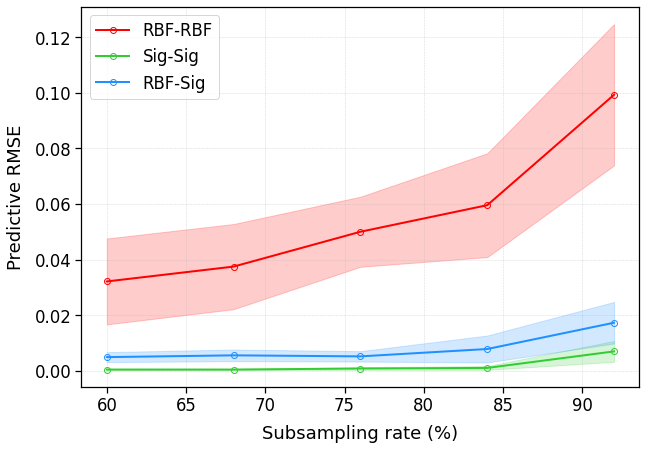

In [62]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
fig,ax = plt.subplots(1,figsize=(10,7))

labels = ['RBF-RBF', 'Sig-Sig','RBF-Sig']
colors = ['red','limegreen','dodgerblue']

for i in [0,1,2]:

    ax.plot([100-100*e/25 for e in subsample],m.iloc[i],color=colors[i],label=labels[i],marker='o',fillstyle='none',lw=2.)
    fact=1
    
    params = np.array([100-100*e/25 for e in subsample])
    plus = m.iloc[i].to_numpy(dtype='float32')  + fact*stdv.iloc[i].to_numpy(dtype='float32')
    minus = m.iloc[i].to_numpy(dtype='float32') - fact*stdv.iloc[i].to_numpy(dtype='float32')

    ax.fill_between(params, minus,plus,alpha=0.2,color=colors[i])


ax.legend()
ax.set_ylabel(r'Predictive RMSE',labelpad=10)
#ax.yaxis.set_ticks(np.arange(0.05, 0.50, 0.05))
ax.set_xlabel(r'Subsampling rate (%)',labelpad=10)
ax.grid(alpha=0.5, linestyle='dashed', linewidth=0.5)
#plt.savefig("comparison_subsampling_phase.pdf", bbox_inches='tight', format='pdf', dpi=1000)
plt.show()